# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

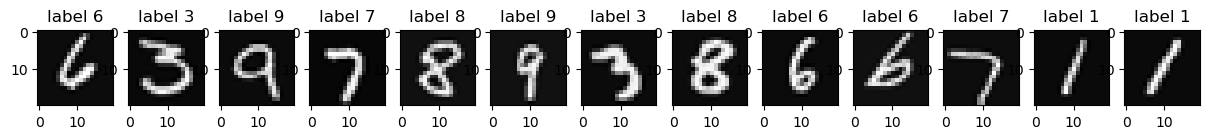

In [5]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [7]:
# def confusion_matrix(y_true, y_pred, num_classes):
#     matrix = np.zeros((num_classes, num_classes))
#     for true_label, pred_label in zip(y_true, y_pred):
#         # Assurer que les étiquettes vraies et prédites sont dans la plage de 0 à num_classes-1
#         true_label = np.clip(true_label, 0, num_classes - 1)
#         pred_label = np.clip(pred_label, 0, num_classes - 1)
#         matrix[true_label][pred_label] += 1
#     return matrix

def confusion_matrix(actual, predicted, labels=None):
    # Vérifie si des libellés sont fournis en entrée
    if labels is None:
        # Si aucun libellé n'est fourni, extrait les libellés uniques à partir des étiquettes réelles et prédites
        labels = np.unique(np.concatenate((actual, predicted)))
        
    # Obtient le nombre total de libellés uniques
    num_labels = len(labels)
    
    # Initialise une matrice de confusion remplie de zéros avec des dimensions correspondant au nombre de libellés uniques
    matrix = np.zeros((num_labels, num_labels), dtype=int)

    # Crée un dictionnaire pour mapper chaque libellé à un index dans la matrice de confusion
    label_to_index = {label: i for i, label in enumerate(labels)}

    # Parcourt chaque paire d'étiquettes réelles et prédites pour incrémenter les compteurs dans la matrice de confusion
    for a, p in zip(actual, predicted):
        # Utilise le dictionnaire de mappage pour obtenir les index correspondants aux étiquettes réelles et prédites
        actual_index = label_to_index[a]
        predicted_index = label_to_index[p]
        
        # Incrémente le compteur correspondant dans la matrice de confusion
        matrix[actual_index][predicted_index] += 1

    # Retourne la matrice de confusion calculée
    return matrix 



- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [8]:
def accuracy_score(y_true, y_pred):
    correct = 0                   # Initialise un compteur pour les prédictions correctes
    for i in range(len(y_true)):  # Parcourt chaque index des listes y_true et y_pred
        if y_true[i] == y_pred[i]:  # Vérifie si la prédiction est correcte
            correct += 1  # Incrémente le compteur de prédictions correctes
    return correct / len(y_true)  # Retourne le ratio des prédictions correctes sur le nombre total de prédictions
#y_true la liste des vals reelles


- Recall (True Positive Rate) = TP/(TP + FN)

In [9]:
# def recall_score(y_true, y_pred, positive_label):
    
#     tp = 0
#     fn = 0
#     for i in range(len(y_true)):
#         if y_true[i] == positive_label:
#             if y_pred[i] == positive_label:
#                 tp += 1
#             else:
#                 fn += 1
#     return tp / (tp + fn)



    
def recall_score(actual, predicted, labels):
    # Initialisation de la variable pour stocker le rappel total
    total_recall = 0
    
    # Nombre total de classes dans le problème de classification
    num_classes = 10
    
    # Boucle à travers chaque classe
    for label in labels:
        # Initialisation des compteurs de vrais positifs et de faux négatifs
        true_positives = 0
        false_negatives = 0
        
        # Itération à travers les valeurs réelles et prédites
        for a, p in zip(actual, predicted):
            # Vérifie si la valeur réelle correspond à l'étiquette de la classe actuelle
            if a == label:
                # Si la valeur prédite correspond également à l'étiquette de la classe actuelle,
                # incrémente le nombre de vrais positifs
                if p == label:
                    true_positives += 1
                # Sinon, incrémente le nombre de faux négatifs
                else:
                    false_negatives += 1
        
        # Calcul du rappel pour la classe actuelle
        if true_positives == 0 and false_negatives == 0:
            recall = 0
        else:
            recall = true_positives / (true_positives + false_negatives)
        
        # Ajout du rappel de la classe actuelle au rappel total
        total_recall += recall
    
    # Calcul du rappel moyen en divisant la somme totale des rappels par le nombre de classes
    average_recall = total_recall / num_classes
    
    # Retourne le rappel moyen
    return average_recall



- Précision = TP/(TP + FP)

In [12]:
# def precision_score(y_true, y_pred, positive_label):
#     tp = 0
#     fp = 0
#     for i in range(len(y_true)):
#         if y_pred[i] == positive_label:
#             if y_true[i] == positive_label:
#                 tp += 1
#             else:
#                 fp += 1
#     return tp / (tp + fp)

def precision_score(y_true, y_pred, labels):
    # Initialisation d'un dictionnaire pour stocker les précisions pour chaque classe
    precisions = {}
    
    # Nombre total de classes
    nb_classes = len(labels)
    
    # Boucle à travers chaque classe
    for label in labels:
        # Initialisation des compteurs de vrais positifs et de faux positifs
        true_positives = 0
        false_positives = 0
        
        # Itération à travers les valeurs réelles et prédites
        for true, pred in zip(y_true, y_pred):
            # Vérifie si la valeur prédite correspond à l'étiquette de la classe actuelle
            if pred == label:
                # Si la valeur prédite correspond également à l'étiquette de la classe actuelle,
                # incrémente le nombre de vrais positifs
                if true == label:
                    true_positives += 1
                # Sinon, incrémente le nombre de faux positifs
                else:
                    false_positives += 1
        
        # Calcul de la précision pour la classe actuelle
        if true_positives == 0 and false_positives == 0:
            precision = 0
        else:
            precision = true_positives / (true_positives + false_positives)
        
        # Stockage de la précision dans le dictionnaire
        precisions[label] = precision
    
    # Calcul de la précision moyenne en faisant la moyenne des précisions pour toutes les classes
    total_precision = sum(precisions.values()) / nb_classes
    
    # Retourne la précision moyenne
    return total_precision


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [13]:
# def false_positive_rate(y_true, y_pred, positive_label):
#     fp = 0
#     tn = 0
#     for i in range(len(y_true)):
#         if y_pred[i] != positive_label:
#             if y_true[i] != positive_label:
#                 tn += 1
#             else:
#                 fp += 1
#     return fp / (fp + tn)

def false_positive_rate(y_true, y_pred, labels):
    # Initialisation d'un dictionnaire pour stocker les taux de faux positifs pour chaque classe
    false_positive_rates = {}
    
    # Nombre total de classes
    nb_classes = 10
    
    # Boucle à travers chaque classe
    for label in labels:
        # Initialisation des compteurs de faux positifs et de vrais négatifs
        false_positives = 0
        true_negatives = 0
        
        # Itération à travers les valeurs réelles et prédites
        for true, pred in zip(y_true, y_pred):
            # Vérifie si la valeur prédite correspond à l'étiquette de la classe actuelle
            if pred == label:
                # Si la valeur prédite correspond à l'étiquette de la classe actuelle
                # et que la valeur réelle est différente de l'étiquette de la classe actuelle,
                # incrémente le nombre de faux positifs
                if true != label:
                    false_positives += 1
            # Si la valeur réelle est différente de l'étiquette de la classe actuelle,
            # incrémente le nombre de vrais négatifs
            elif true != label:
                true_negatives += 1
        
        # Calcul du taux de faux positifs pour la classe actuelle
        if false_positives == 0 and true_negatives == 0:
            false_positive_rate = 0
        else:
            false_positive_rate = false_positives / (false_positives + true_negatives)
        
        # Stockage du taux de faux positifs dans le dictionnaire
        false_positive_rates[label] = false_positive_rate
    
    # Calcul du taux de faux positifs moyen en faisant la moyenne des taux de faux positifs pour toutes les classes
    total = sum(false_positive_rates.values()) / nb_classes
    
    # Retourne le taux de faux positifs moyen
    return total

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [14]:
# def specificity_score(y_true, y_pred, negative_label):
#     tn = 0
#     fp = 0
#     for i in range(len(y_true)):
#         if y_true[i] == negative_label:
#             if y_pred[i] == negative_label:
#                 tn += 1
#             else:
#                 fp += 1
#     return tn / (tn + fp)
def specificity_score(y_true, y_pred, labels):
    # Initialisation d'un dictionnaire pour stocker les spécificités pour chaque classe
    specificities = {}
    
    # Nombre total de classes
    nb_classes = len(labels)
    
    # Boucle à travers chaque classe
    for label in labels:
        # Calcul du nombre de vrais négatifs (TN) pour la classe actuelle
        true_negatives = sum(1 for true, pred in zip(y_true, y_pred) if true == label and pred == label)
        
        # Calcul du nombre de faux positifs (FP) pour la classe actuelle
        false_positives = sum(1 for true, pred in zip(y_true, y_pred) if true == label and pred != label)
        
        # Calcul de la spécificité pour la classe actuelle
        if true_negatives == 0 and false_positives == 0:
            specificity = 0
        else:
            specificity = true_negatives / (true_negatives + false_positives)
        
        # Stockage de la spécificité dans le dictionnaire
        specificities[label] = specificity
    
    # Calcul de la spécificité moyenne en faisant la moyenne des spécificités pour toutes les classes
    total_specificity = sum(specificities.values()) / nb_classes
    
    # Retourne la spécificité moyenne
    return total_specificity



- Courbe ROC

In [15]:
# def roc_curve(y_true, y_pred, positive_label):
#     tpr = []
#     fpr = []
#     thresholds = sorted(set(y_pred), reverse=True)
#     for threshold in thresholds:
#         binarized_predictions = [1 if pred >= threshold else 0 for pred in y_pred]
#         tpr.append(recall_score(y_true, binarized_predictions, positive_label))
#         fpr.append(false_positive_rate(y_true, binarized_predictions, positive_label))
#     return fpr, tpr

def roc_curve(actual, predicted_probabilities):
    """
    Calculer la courbe ROC.
    Args:
    actual (array-like): Une liste ou un tableau contenant les valeurs réelles.
    predicted_probabilities (array-like): Une liste ou un tableau contenant les probabilités prédites pour la classe positive.
    positive_label: La valeur de l'étiquette positive.

    Returns:
    tuple: Un tuple contenant deux listes, une pour les taux de vrais positifs (TPR) et une pour les taux de faux positifs (FPR).
    """
    # Liste des seuils à utiliser pour binariser les prédictions de probabilité
    thresholds= [1,2,3,4,5,6,7,8,9,10]
    
    # Liste pour stocker les taux de vrais positifs (TPR)
    tpr_list = []  
    
    # Liste pour stocker les taux de faux positifs (FPR)
    fpr_list = []  
    
    # Boucle à travers chaque seuil
    for threshold in thresholds:
        # Binarisation des prédictions de probabilité en utilisant le seuil actuel
        labels=[1,2,3,4,5,6,7,8,9,10]
        predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probabilities]  
        #Cela permet de convertir les prédictions de probabilité en prédictions binaires.
        
        # Calcul du taux de vrais positifs (TPR) en utilisant la fonction recall_score
        tpr = recall_score(actual, predicted_labels, labels)
        
        # Calcul du taux de faux positifs (FPR) en utilisant la fonction false_positive_rate
        fpr = false_positive_rate(actual, predicted_labels, labels)
        
        # Ajout du TPR calculé à la liste des TPR
        tpr_list.append(tpr)
        
        # Ajout du FPR calculé à la liste des FPR
        fpr_list.append(fpr)

    # Retourne les listes des TPR et FPR calculés
    return tpr_list, fpr_list


# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [16]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

K = 1:
[[135   1   0   0   0   0   0   0   1   0]
 [  3 144   4   2   1   2   0   4   0   1]
 [  3   4 127   0  12   1   1   4   3   0]
 [  3   1   0 130   1   1   5   0  13   0]
 [  0   0   9   2 119   5   1   2   4   2]
 [  1   1   0   0   0 145   0   1   0   3]
 [  6   1   2   5   0   0 142   0  11   0]
 [  4   3   7   0   9   2   1 116   5   3]
 [  1   3   1  10   1   1   5   2 111   3]
 [  0   1   1   0   3   5   0   1   1 131]]
Accuracy: 0.8666666666666667
Recall: 0.7713775446198434
Precision: 0.8632381548468889
False Positive Rate: 0.013534684085268039
Specificity: 0.8570861606887149


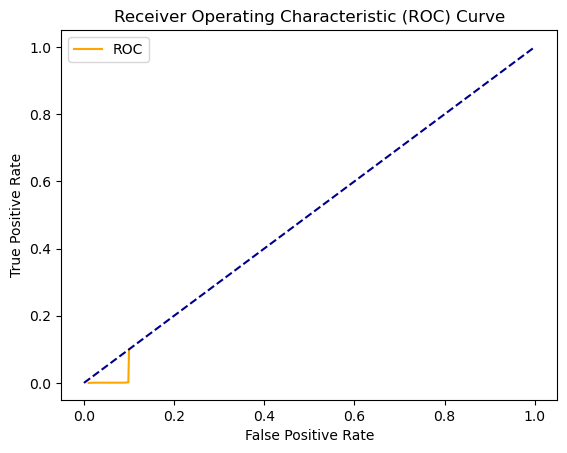

K = 3:
[[133   1   1   1   0   0   0   0   1   0]
 [  6 137   3   4   0   3   1   4   1   2]
 [  4   5 131   0   8   1   2   2   2   0]
 [  6   0   1 133   1   0   1   0  12   0]
 [  1   3   9   2 118   3   1   1   4   2]
 [  1   0   0   0   2 145   0   1   0   2]
 [  6   2   3   4   1   0 141   0  10   0]
 [  6   3   8   1  11   1   0 114   4   2]
 [  1   2   2   9   2   1   4   1 113   3]
 [  0   0   1   0   3   3   0   1   0 135]]
Accuracy: 0.8666666666666667
Recall: 0.771718459614165
Precision: 0.861652801677177
False Positive Rate: 0.013899025852994074
Specificity: 0.85746495512685


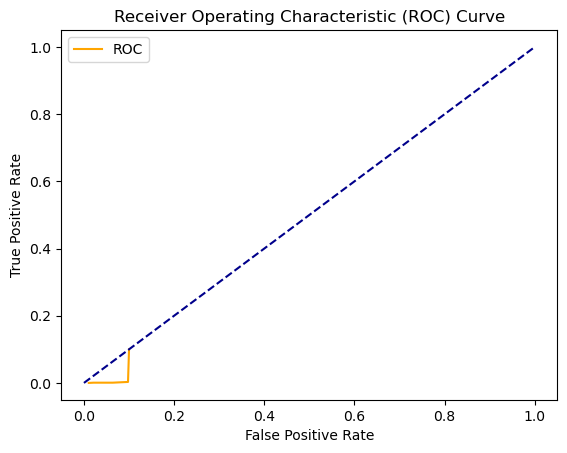

K = 5:
[[134   1   1   0   0   0   1   0   0   0]
 [  8 136   5   2   1   3   0   4   0   2]
 [  4   2 132   1   7   2   1   3   3   0]
 [  5   1   0 131   0   0   2   0  15   0]
 [  0   0   9   1 121   4   0   2   5   2]
 [  1   0   1   0   2 146   0   0   0   1]
 [  7   0   2   4   1   0 140   0  13   0]
 [  5   4   6   0  12   4   1 112   4   2]
 [  1   1   2  10   0   1   3   2 115   3]
 [  0   0   1   0   3   2   0   0   0 137]]
Accuracy: 0.8693333333333333
Recall: 0.7741728029663738
Precision: 0.8681097925606704
False Positive Rate: 0.013297414963580135
Specificity: 0.8601920032959709


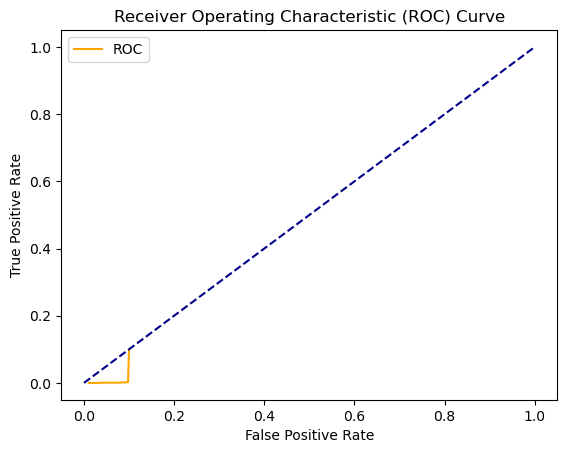

K = 7:
[[134   1   1   0   0   0   1   0   0   0]
 [  8 137   2   2   0   3   1   6   0   2]
 [  3   2 134   0   7   2   2   2   3   0]
 [  6   0   0 126   2   0   3   0  17   0]
 [  0   0   8   2 120   5   0   1   5   3]
 [  1   0   0   1   3 144   0   1   0   1]
 [  9   0   2   4   0   0 138   0  14   0]
 [  7   2   5   1  14   1   0 115   4   1]
 [  1   1   2  10   1   1   4   1 114   3]
 [  0   0   0   0   3   2   0   1   0 137]]
Accuracy: 0.866
Recall: 0.7722208033966651
Precision: 0.863762075727898
False Positive Rate: 0.013809359672358242
Specificity: 0.8580231148851835


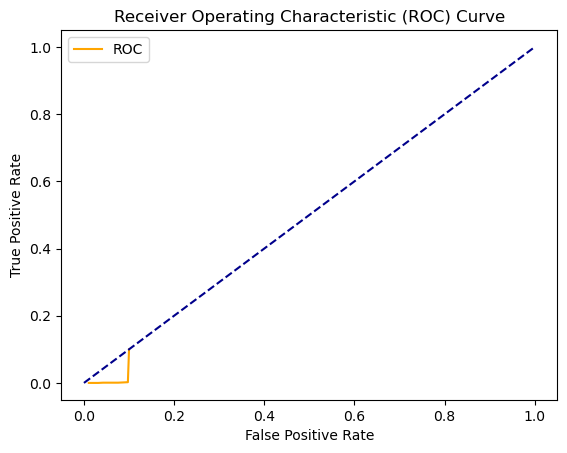

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# def euclidean_distance(point1, point2):
#     # Calculate the Euclidean distance between two points
#     return np.sqrt(np.sum((point1 - point2)**2))

# def k_nearest_neighbors(X_train, y_train, X_test, k):
#     predictions = []
#     for test_point in X_test:
#         # Calculate distances between the test point and all points in the training set
#         distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
#         # Get indices of k nearest neighbors
#         nearest_indices = np.argsort(distances)[:k]
#         # Get labels of k nearest neighbors
#         nearest_labels = [y_train[i] for i in nearest_indices]
#         # Predict the label based on majority vote
#         predicted_label = max(set(nearest_labels), key=nearest_labels.count)
#         predictions.append(predicted_label)
#     return predictions


# knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model with the training data

# Méthode 0: K- Plus Proches Voisins
# Tester différentes valeurs de K et évaluer les performances du modèle
K_values = [1,3,5,7]  # Valeurs de K à tester
for k in K_values:
    # Prédire les étiquettes pour les données de test
#     y_pred = k_nearest_neighbors(Xt, Yt, Xtt, k)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(Xt, Yt)
    y_pred = knn_model.predict(Xtt)
    # Calculer les métriques de performance
#     conf_matrix = confusion_matrix(Ytt, y_pred, num_classes=10)
    conf_matrix = confusion_matrix(Ytt, y_pred)

    acc = accuracy_score(Ytt, y_pred)

    labels = [1, 2,3,4,5,7,8,9,10]
    recall = recall_score(Ytt, y_pred, labels)
    
    
    
    precision = precision_score(Ytt, y_pred,labels)  # Étiquette positive pour le chiffre 0
    fpr = false_positive_rate(Ytt, y_pred, labels)  # Étiquette positive pour le chiffre 0
    specificity = specificity_score(Ytt, y_pred, labels)  # Étiquette négative pour le chiffre 0
#     roc_fpr, roc_tpr = roc_curve(Ytt, y_pred, positive_label=10)  # Étiquette positive pour le chiffre 0
    
    # Afficher les résultats
    print(f"K = {k}:")
    
    print(conf_matrix)
    print(f"Accuracy: {acc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"False Positive Rate: {fpr}")
    print(f"Specificity: {specificity}")
    
    import matplotlib.pyplot as plt
    
    def plot_roc_curve(fpr, tpr):
        plt.plot(fpr, tpr, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()


    tpr, fpr = roc_curve(Ytt, y_pred)
    plot_roc_curve(fpr, tpr)
    
    
    
#     print("\n")

K = 1:
Confusion Matrix:
[[135   1   0   0   0   0   0   0   1   0]
 [  3 144   4   2   1   2   0   4   0   1]
 [  3   4 127   0  12   1   1   4   3   0]
 [  3   1   0 130   1   1   5   0  13   0]
 [  0   0   9   2 119   5   1   2   4   2]
 [  1   1   0   0   0 145   0   1   0   3]
 [  6   1   2   5   0   0 142   0  11   0]
 [  4   3   7   0   9   2   1 116   5   3]
 [  1   3   1  10   1   1   5   2 111   3]
 [  0   1   1   0   3   5   0   1   1 131]]
Accuracy: 0.8666666666666667
Recall: 0.7713775446198434
Precision: 0.8632381548468889
False Positive Rate: 0.013534684085268039
Specificity: 0.8570861606887149


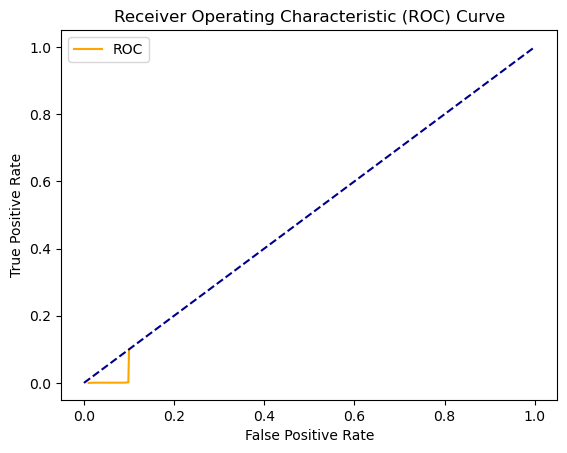

K = 3:
Confusion Matrix:
[[133   1   1   1   0   0   0   0   1   0]
 [  5 134   3   4   0   3   1   6   2   3]
 [  4   3 128   0   8   1   2   6   3   0]
 [  6   0   0 129   0   0   1   2  15   1]
 [  0   1   6   0 117   3   0   9   5   3]
 [  1   0   0   0   0 145   0   3   0   2]
 [  6   2   1   2   0   0 141   0  15   0]
 [  4   1   3   0   8   1   0 126   5   2]
 [  1   1   1   4   0   1   4   6 117   3]
 [  0   0   1   0   3   2   0   1   1 135]]
Accuracy: 0.87
Recall: 0.7755263253887207
Precision: 0.8663489969612298
False Positive Rate: 0.013588164760474206
Specificity: 0.8616959170985785


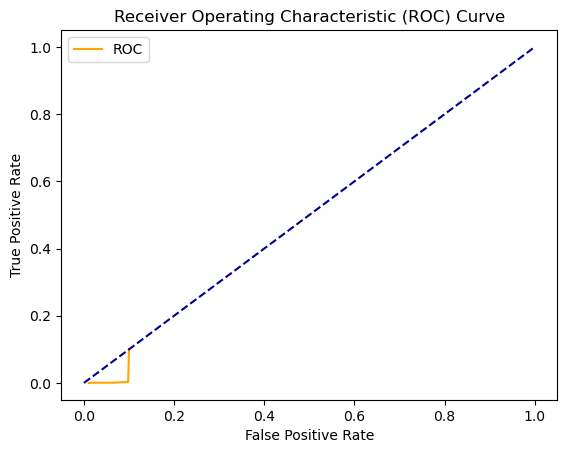

K = 5:
Confusion Matrix:
[[134   1   1   0   0   0   0   0   1   0]
 [  7 134   5   1   0   3   0   8   1   2]
 [  4   2 132   1   7   2   1   3   3   0]
 [  5   1   0 127   0   0   2   1  18   0]
 [  0   0   9   1 116   3   0   7   5   3]
 [  1   0   1   0   2 144   0   2   0   1]
 [  7   0   2   4   0   0 137   0  17   0]
 [  3   3   5   0  10   1   0 121   5   2]
 [  1   1   2   5   0   1   2   2 121   3]
 [  0   0   0   0   3   2   0   1   0 137]]
Accuracy: 0.8686666666666667
Recall: 0.7754123610232321
Precision: 0.8664872308481648
False Positive Rate: 0.01365899334129222
Specificity: 0.8615692900258134


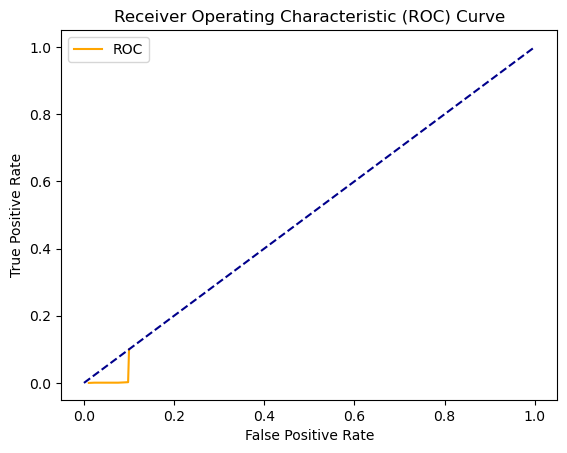

K = 7:
Confusion Matrix:
[[134   1   1   0   0   0   1   0   0   0]
 [  8 134   2   2   0   3   1   9   0   2]
 [  2   2 134   0   7   2   2   3   3   0]
 [  6   0   0 124   2   0   3   1  18   0]
 [  0   0   8   2 116   5   0   5   5   3]
 [  1   0   0   1   2 142   0   2   0   3]
 [  9   0   2   4   0   0 136   0  16   0]
 [  4   1   4   1   9   1   0 125   4   1]
 [  1   1   2   6   0   1   4   2 118   3]
 [  0   0   0   0   3   2   0   1   0 137]]
Accuracy: 0.8666666666666667
Recall: 0.7746485828838041
Precision: 0.8645503985967518
False Positive Rate: 0.013735919403039004
Specificity: 0.8607206476486712


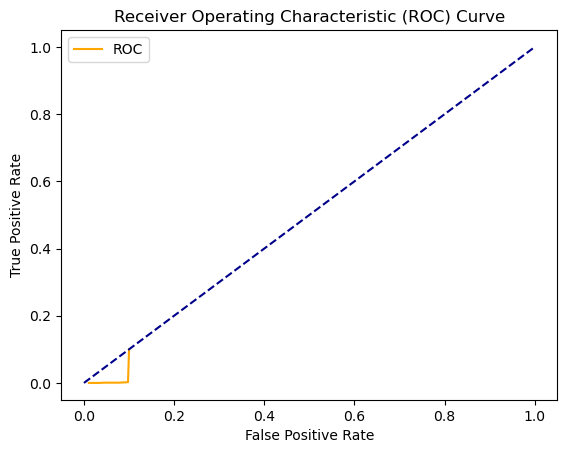

In [18]:
# Définition de la fonction de distance euclidienne
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

# Définition de l'algorithme KNN
# Définition de l'algorithme KNN
def k_nearest_neighbors(Xt, Yt, Xtt, k):
    predictions = []
    for test_point in Xtt:
        # Calcul des distances entre le point de test et tous les points dans l'ensemble de données d'entraînement
        distances = [euclidean_distance(test_point, train_point) for train_point in Xt]
        # Obtenir les indices des K plus proches voisins
        nearest_indices = np.argsort(distances)[:k]
        # Obtenir les étiquettes des K plus proches voisins
        nearest_labels = [Yt[i] for i in nearest_indices]
        # Prédire l'étiquette en effectuant un vote majoritaire parmi les étiquettes des voisins
        predicted_label = max(set(nearest_labels), key=nearest_labels.count)
        predictions.append(predicted_label)
    return predictions

# Tester différentes valeurs de k et évaluer les performances du modèle
K_values = [1, 3, 5, 7]  # Valeurs de k à tester


# Valeur de k à tester
K_values = [1, 3, 5, 7]

# Tester différentes valeurs de k et évaluer les performances du modèle
for k in K_values:
    # Prédire les étiquettes pour les données de test
    y_pred = k_nearest_neighbors(Xt, Yt, Xtt, k)
    # Calculer les métriques de performance
    conf_matrix = confusion_matrix(Ytt, y_pred)
    acc = accuracy_score(Ytt, y_pred)
    #recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recall = recall_score(Ytt, y_pred, labels)
    precision = precision_score(Ytt, y_pred,labels)  # Étiquette positive pour le chiffre 0
    fpr = false_positive_rate(Ytt, y_pred, labels)  # Étiquette positive pour le chiffre 0
    specificity = specificity_score(Ytt, y_pred, labels)  # Étiquette négative pour le chiffre 0
    
    # Affichage des résultats
    print(f"K = {k}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {acc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"False Positive Rate: {fpr}")
    print(f"Specificity: {specificity}")
    
    def plot_roc_curve(fpr, tpr):
        plt.plot(fpr, tpr, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()


    tpr, fpr = roc_curve(Ytt, y_pred)
    plot_roc_curve(fpr, tpr)

# Méthode 1: MVS
Machine à Vecteurs de Support

SVM:
Confusion Matrix:
[[132   2   0   2   0   0   0   0   1   0]
 [  0 147   2   4   0   1   1   3   0   3]
 [  1   6 135   1   7   0   2   2   0   1]
 [  0   1   0 149   0   1   0   0   3   0]
 [  2   4   7   3 123   2   1   2   0   0]
 [  0   2   0   2   0 145   0   1   0   1]
 [  1   1   1   1   0   0 157   0   6   0]
 [  1   5   7   0   1   1   0 133   2   0]
 [  1   0   3   7   0   0   5   2 118   2]
 [  0   2   1   0   4   0   0   0   0 136]]
Accuracy: 0.9166666666666666
Recall: 0.82021218459933
Precision: 0.9126638304504601
False Positive Rate: 0.008902893923057828
Specificity: 0.9113468717770333


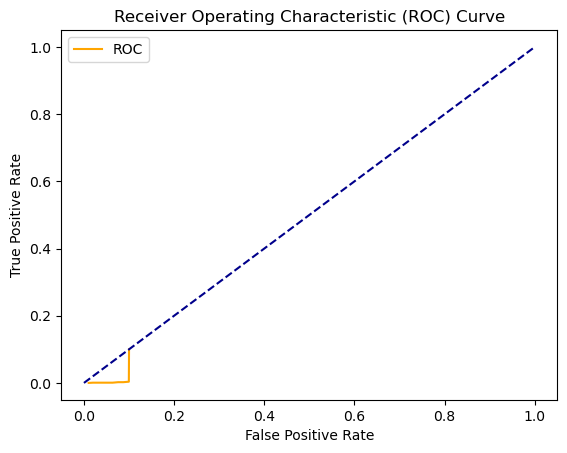

In [19]:
# Création du modèle SVM avec un noyau linéaire
model = svm.SVC(kernel='linear') 

# Entrainement du modèle sur les données d'entrainement
model.fit(Xt, Yt)

# Prédiction des étiquettes sur les données de test
y_pred = model.predict(Xtt)

# Calcul des métriques de performance
conf_matrix = confusion_matrix(Ytt, y_pred)  # Matrice de confusion
acc = accuracy_score(Ytt, y_pred)  # Accuracy
recall = recall_score(Ytt, y_pred, labels)  # Recall
precision = precision_score(Ytt, y_pred, labels)  # Precision
fpr = false_positive_rate(Ytt, y_pred, labels)  # False Positive Rate
specificity = specificity_score(Ytt, y_pred, labels)  # Specificity

# Affichage des résultats
print("SVM:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"False Positive Rate: {fpr}")
print(f"Specificity: {specificity}")

# Calcul de la courbe ROC
tpr, fpr = roc_curve(Ytt, y_pred)

# Affichage de la courbe ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



8


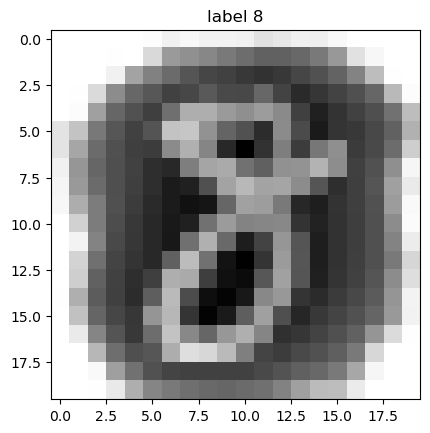

In [22]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


Decision Tree:
[[122   2   1   2   5   1   2   2   0   0]
 [  5 112   7   4   5   7   5  10   4   2]
 [  3   6 120   5   6   3   6   1   3   2]
 [  2   2   2 125   4   4   1   3   9   2]
 [  1   4  10   3  90   4   5  15   7   5]
 [  1   4   0   3   5 120   1  13   2   2]
 [  6   8  10   3   2   0 128   0   9   1]
 [  1   9   6   4  13   3   4 104   4   2]
 [  0   1   3   9   3   0   4   4 112   2]
 [  0   3   0   1   4   4   6   4   3 118]]
Accuracy: 0.7673333333333333
Recall: 0.6893614410168534
Precision: 0.7623609130044618
False Positive Rate: 0.023937537068173816
Specificity: 0.7659571566853927


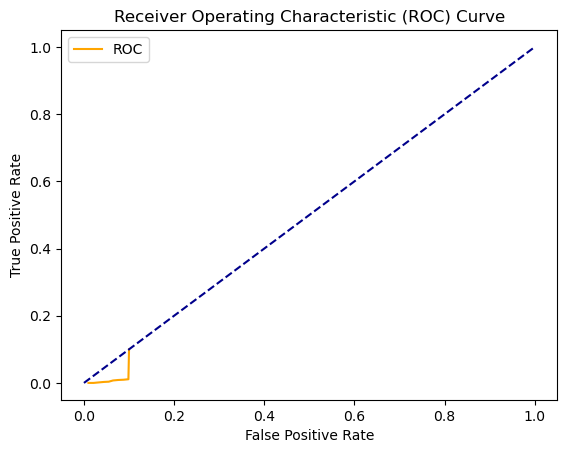

In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(Xt, Yt)
y_pred = model.predict(Xtt)

# Calcul des métriques de performance
conf_matrix = confusion_matrix(Ytt, y_pred)
acc = accuracy_score(Ytt, y_pred)
recall = recall_score(Ytt, y_pred, labels)
precision = precision_score(Ytt, y_pred, labels)
fpr = false_positive_rate(Ytt, y_pred, labels)
specificity = specificity_score(Ytt, y_pred, labels)

# Affichage des résultats
print("Decision Tree:")
print(conf_matrix)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"False Positive Rate: {fpr}")
print(f"Specificity: {specificity}")

# Calcul de la courbe ROC
tpr, fpr = roc_curve(Ytt, y_pred)

# Affichage de la courbe ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



5


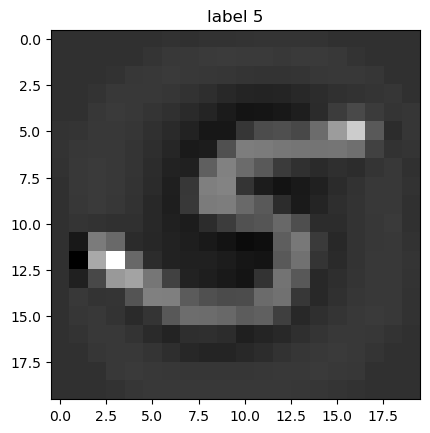

In [37]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [21]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)


model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25), max_iter=100000)
model.fit(Xt, Yt)
y_pred = model.predict(Xtt)

# Calcul des métriques de performance
conf_matrix = confusion_matrix(Ytt, y_pred)
acc = accuracy_score(Ytt, y_pred)
recall = recall_score(Ytt, y_pred, labels)
precision = precision_score(Ytt, y_pred, labels)
fpr = false_positive_rate(Ytt, y_pred, labels)
specificity = specificity_score(Ytt, y_pred, labels)

# Affichage des résultats
print("MLP:")
print(conf_matrix)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"False Positive Rate: {fpr}")
print(f"Specificity: {specificity}")


MLP:
[[  0   2   0 348   0   1   0   0   0   0]
 [  0   5   0 314   0  34   0   1   0   0]
 [  0   0   0 357   0   1   0   0   0   0]
 [  0   4   0 327   0   7   0   0   0   0]
 [  0   0   0 347   0   3   0   1   0   0]
 [  0   6   0  30   0 307   0   0   0   0]
 [  0   0   0 349   0   1   0   0   0   0]
 [  0   0   0 347   0   3   0   0   0   0]
 [  0   0   0 349   0   2   0   0   0   0]
 [  0   1   0 351   0   2   0   0   0   0]]
Accuracy: 0.18257142857142858
Recall: 0.09815799150870859
Precision: 0.04251323034052542
False Positive Rate: 0.08877526042852936
Specificity: 0.1090644350096762


In [39]:
# Choisir un image de test 
c=0

In [40]:
model.predict([Xtt[c,:]])

array([1])

In [41]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[0.11408998, 0.11134124, 0.09899884, 0.11283984, 0.09044074,
        0.0939826 , 0.09341599, 0.10840574, 0.08554108, 0.09094396]])

Afficher l'image testée

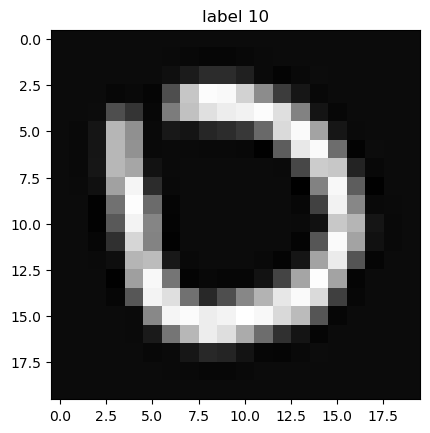

In [42]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat